In [1351]:
# to import conll
import os
import subprocess
import sys
sys.path.insert(0, os.path.abspath('./src/'))

from conll import evaluate
# for nice tables
import pandas as pd

from tqdm.notebook import tqdm

In [1299]:
def execute(cmd):
    return subprocess.check_output(cmd, shell=True).decode(sys.stdout.encoding)

In [1300]:
# Let's define a function to simplify working with data
# get column from loaded corpus (tokens are tuples)
def get_column(corpus, column=-1):
    return [[word[column] for word in sent] for sent in corpus]

In [1301]:
# modified version to support fst-output
def read_fst4conll(fst_file, fs="\t", oov='<unk>', otag='O', sep='+', split=False):
    """
    :param corpus_file: corpus in conll format
    :param fs: field separator
    :param oov: token to map to otag (we need to get rid of <unk> in labels)
    :param otag: otag symbol
    :param sep: 
    :param split:
    :return: corpus 
    """
    sents = []  # list to hold words list sequences
    words = []  # list to hold feature tuples

    for line in open(temp_folder + fst_file):
        line = line.strip()
        if len(line.strip()) > 0:
            feats = tuple(line.strip().split(fs))
            # arc has minimum 3 columns, else final state
            if len(feats) >= 3:
                ist = feats[2]  # 3rd column (input)
                ost = feats[3]  # 4th column (output)
                # replace '<unk>' with 'O'
                ost = otag if ost == oov else ost
                # ignore for now
                ost = ost.split(sep)[1] if split and ost != otag else ost
                
                words.append((ist, ost))
            else:
                sents.append(words)
                words = []
        else:
            if len(words) > 0:
                sents.append(words) 
                words = []
    return sents

In [1302]:
def read_corpus_conll(corpus_file, fs="\t"):
    """
    read corpus in CoNLL format
    :param corpus_file: corpus in conll format
    :param fs: field separator
    :return: corpus
    """
    featn = None  # number of features for consistency check
    sents = []  # list to hold words list sequences
    words = []  # list to hold feature tuples

    for line in open(corpus_file):
        line = line.strip()
        if len(line.strip()) > 0:
            feats = tuple(line.strip().split(fs))
            if not featn:
                featn = len(feats)
            elif featn != len(feats) and len(feats) != 0:
                raise ValueError("Unexpected number of columns {} ({})".format(len(feats), featn))

            words.append(feats)
        else:
            if len(words) > 0:
                sents.append(words)
                words = []
    return sents

In [1303]:
def compute_frequency_list(corpus):
    """
    create frequency list for a corpus
    :param corpus: corpus as list of lists
    """
    frequencies = {}
    for sent in corpus:
        for token in sent:
            frequencies[token] = frequencies.setdefault(token, 0) + 1
    return frequencies

In [1304]:
def cutoff(corpus, tf_min=2):
    """
    apply min cutoffs
    :param tf_min: minimum token frequency for lexicon elements (below removed); default 2
    :return: lexicon as set
    """
    frequencies = compute_frequency_list(corpus)
    return sorted([token for token, frequency in frequencies.items() if frequency >= tf_min])

In [1305]:
temp_folder = 'tmp/'
wdir = temp_folder + 'wdir_wt/'

In [1306]:
dpath = 'dataset/'

def init():
    execute('mkdir -p ' + temp_folder)

    execute('cp {}NL2SparQL4NLU.train.utterances.txt {}trn.txt'.format(dpath, temp_folder))
    execute('cp {}NL2SparQL4NLU.test.utterances.txt {}tst.txt'.format(dpath, temp_folder))

    execute('cp {}NL2SparQL4NLU.train.conll.txt {}trn.conll'.format(dpath, temp_folder))
    execute('cp {}NL2SparQL4NLU.test.conll.txt {}tst.conll'.format(dpath, temp_folder))

In [1307]:
init()

## Input generalization functions

In [1583]:
import requests
from num2words import num2words
import spacy


def valid_regex(txt):
    try:
        re.compile(txt)
        return True
    except:
        return False
    
def clean_dt(dt):
    dt = list(filter(lambda x: valid_regex(x), dt))
    return list(map(lambda x: x.lower(), dt))

def get_persons():
    #r_fn = requests.get('https://github.com/philipperemy/name-dataset/raw/master/names_dataset/first_names.all.txt')
    #r_ln = requests.get('https://github.com/philipperemy/name-dataset/raw/master/names_dataset/last_names.all.txt')
    #r_fn = requests.get('https://github.com/philipperemy/name-dataset/raw/master/eng_dictionary/names-from-forbes-wp_users.txt')
    r = requests.get('https://github.com/organisciak/names/raw/master/data/us-names-by-gender.csv')
    names = list(filter(None, r.text.split('\n')[1:]))
    fn = clean_dt([i.split(',')[1] for i in names])
    #ln = clean_dt(r_ln.text.split('\n'))
    return fn, []

def get_number_lett():
    words = []
    for i in range(150):
        words.append(num2words(i, to='cardinal'))
        words.append(num2words(i, to='ordinal'))
        words.append(num2words(i, to='ordinal').replace('-', ''))
    return clean_dt(words)

def get_geo_places():
    geo = set()

    r = requests.get('https://github.com/zutherb/city-country-dataset/raw/master/city')
    cities = list(filter(None, r.text.split('\n')))
    geo.update([i.split(',')[1] for i in cities])

    r = requests.get('https://github.com/zutherb/city-country-dataset/raw/master/country')
    countries = list(filter(None, r.text.split('\n')))
    geo.update([i.split(',')[1] for i in countries])
    
    geo.update([i.split(',')[2] for i in countries])  # continent
    
    return clean_dt(list(geo))

In [1584]:
import re

persons_fn, persons_ln = get_persons()
persons = persons_fn + persons_ln
geo_places = get_geo_places()
number_lett = get_number_lett()

norm_rules = {
    'num': [r'^(\d+|' + '|'.join(number_lett) + ')$', '<num>'],
    'person': ['^(' + '|'.join(persons) + ')$', '<person>'],
    #'person_ln': ['^(' + '|'.join(persons_ln) + ')$', '<personln>'],
    'geo_place': ['^(' + '|'.join(geo_places) + ')$', '<geoplace>'],
    #'num_lett': ['^(' + '|'.join(number_lett) + ')$', '<numlett>']
}

In [1493]:
def normalize_dataset_old(inp, out, rules):
    lines = []

    f = open(temp_folder + inp, "r")
    for line in f.readlines():
        if line == '\n':
            lines.append(line)
            continue

        words = line.split('\t')
        
        for r in rules:
            rule = norm_rules[r]
            words[0] = re.sub(rule[0], rule[1], words[0])
        lines.append(words[0] + '\t' + words[1])
        
    with open(temp_folder + out, 'w') as f:
        for s in lines:
            f.write(s)

In [ ]:
%bash
python -m spacy download en_core_web_sm

In [ ]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [1640]:
norm_rules = ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LAW', 'LANGUAGE',
              'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL']

In [1639]:
def normalize_dataset(inp, out, rules):
    lines = []

    f = open(temp_folder + inp, "r")
    words = []
    for line in f.readlines():
        if line == '\n':
            phrase = ' '.join([w[0] for w in words])
            doc = nlp(phrase)
            
            for ent in doc.ents:
                if ent.label_ in rules:
                    for el in range(ent.start, ent.end):
                        if el < len(words):
                            words[el][0] = ent.label_

            new_line = ['\t'.join(l) for l in words]                
            
            lines += new_line + ['\n']
            words = []
        else:
            words.append(line.split('\t'))
        
    with open(temp_folder + out, 'w') as f:
        for s in lines:
            f.write(s)

## SCLM functions

In [1308]:
from enum import IntEnum

class Baseline(IntEnum):
    none = 0
    random_path = 1
    output_symbol_priors = 2
    MLE = 3

In [1488]:
def create_training_data(min_freq=2, inp='trn.conll'):
    # create training data in utterance-per-line format for output symbols (w+t)
    trn = read_corpus_conll(temp_folder + inp)
    wt_sents = [["+".join(w) for w in s] for s in trn]
    wt_osyms = cutoff(wt_sents, min_freq)
    wt_isyms = [w.split('+')[0] for w in wt_osyms]

    
    with open(temp_folder + 'trn.wt.txt', 'w') as f:
        for s in wt_sents:
            f.write(" ".join(s) + "\n")

    with open(temp_folder + 'osyms.wt.lst.txt', 'w') as f:
        f.write("\n".join(wt_osyms) + "\n")

    with open(temp_folder + 'isyms.wt.lst.txt', 'w') as f:
        f.write("\n".join(wt_isyms) + "\n")
        
        
    tags = get_column(trn, column=-1)
    with open(temp_folder + 'trn.t.txt', 'w') as f:
        for s in tags:
            f.write(" ".join(s) + "\n")

    t_osyms = list(set([ x.split('+')[1] for x in wt_osyms ]))
    with open(temp_folder + 'osyms.t.lst.txt', 'w') as f:
        f.write("\n".join(t_osyms) + "\n")

In [1310]:
def create_symbol_table():
    execute('ngramsymbols {0}osyms.wt.lst.txt {0}osyms.wt.txt'.format(temp_folder))
    execute('ngramsymbols {0}isyms.wt.lst.txt {0}isyms.wt.txt'.format(temp_folder))
    
    execute('ngramsymbols {0}osyms.t.lst.txt {0}osyms.t.txt'.format(temp_folder))

In [1311]:
def create_msyms(isyms, osyms, out_msyms, out_trn):
    execute('cat {0}{1} {0}{2} | cut -f 1 | sort | uniq > {0}msyms.m.lst.txt'
            .format(temp_folder, isyms, osyms))
    execute('ngramsymbols {0}msyms.m.lst.txt {0}{1}'.format(temp_folder, out_msyms))

    execute("cat {0}trn.conll | sed '/^$/d' | awk '{{print $2,$1}}' > {0}{1}".format(temp_folder, out_trn))

In [1312]:
def compile_FAR(symbols, inp, out):
    execute("farcompilestrings \
        --symbols={0}{1} \
        --keep_symbols \
        --unknown_symbol='<unk>' \
        {0}{2} {0}{3}".format(temp_folder, symbols, inp, out))

In [1313]:
def train_ngram_model(ngram_order, inp, out, method='katz'):
    execute('ngramcount --order={1} {0}{2} {0}trn.cnt'.format(temp_folder, ngram_order, inp))
    execute('ngrammake --method={2} {0}trn.cnt {0}{1}'.format(temp_folder, out, method))

    lines = execute('ngraminfo {0}{1}'.format(temp_folder, out)).split('\n')
    info = [list(filter(None, x.split('  '))) for x in lines][:-3]
    return info

In [1314]:
def create_ngram_probs(symbols, inp, out):
    execute('ngramprint \
        --symbols={0}{1}\
        --negativelogs \
        {0}{2} {0}{3}'.format(temp_folder, symbols, inp, out))

In [1315]:
def make_w2t_wt(isyms, sep='+', out=''):
    special = {'<epsilon>', '<s>', '</s>'}
    oov = '<unk>'  # unknown symbol
    state = '0'    # wfst specification state
    fs = " "       # wfst specification column separator
    
    ist = sorted(list(set([line.strip().split("\t")[0] for line in open(temp_folder + isyms, 'r')]) - special))
    
    
    with open(temp_folder + out, 'w') as f:
        for e in ist:
            f.write(fs.join([state, state, e.split(sep)[0], e]) + "\n")
        f.write(state + "\n")

In [1316]:
def make_w2t(isyms, osyms, out):
    special = {'<epsilon>', '<s>', '</s>'}
    oov = '<unk>'  # unknown symbol
    state = '0'    # wfst specification state
    fs = " "       # wfst specification column separator
    
    ist = sorted(list(set([line.strip().split("\t")[0] for line in open(temp_folder + isyms, 'r')]) - special))
    ost = sorted(list(set([line.strip().split("\t")[0] for line in open(temp_folder + osyms, 'r')]) - special))
    
    with open(temp_folder + out, 'w') as f:
        for i in range(len(ist)):
            for j in range(len(ost)):
                f.write(fs.join([state, state, ist[i], ost[j]]) + "\n")
        f.write(state + "\n")

In [1317]:
def make_w2t_mle(probs, out):
    special = {'<epsilon>', '<s>', '</s>'}
    oov = '<unk>'  # unknown symbol
    state = '0'    # wfst specification state
    fs = " "       # wfst specification column separator
    otag = 'O'
    mcn = 3        # minimum column number
    
    lines = [line.strip().split("\t") for line in open(temp_folder + probs, 'r')]

    with open(temp_folder + out, 'w') as f:
        for line in lines:
            ngram = line[0]
            ngram_words = ngram.split()  # by space
            if len(ngram_words) == 2:
                if set(ngram_words).isdisjoint(set(special)):
                    if ngram_words[0] in [otag, oov]:
                        f.write(fs.join([state, state] + ngram_words + [line[1]]) + "\n")
                    elif ngram_words[0].startswith("B-") or ngram_words[0].startswith("I-"):
                        f.write(fs.join([state, state] + line) + "\n")
        f.write(state + "\n")

In [1318]:
def compile_fst(isyms, osyms, inp, out, invert=False):
    execute('fstcompile \
        --isymbols={0}{1} \
        --osymbols={0}{2} \
        --keep_isymbols \
        --keep_osymbols \
        {0}{3} {0}{4}'.format(temp_folder, isyms, osyms, inp, out))
    
    if invert:
        execute('fstinvert {0}{1} {0}{1}'.format(temp_folder, out))

In [1319]:
def compile_testing_and_extract(symbols, inp):
    execute("farcompilestrings \
        --symbols={0}{1} \
        --keep_symbols \
        --initial_symbols=false \
        --unknown_symbol='<unk>' \
        {0}{2} {0}tst.wt.far".format(temp_folder, symbols, inp))

    execute('rm -r -f ' + wdir)
    execute('mkdir ' + wdir)

    execute('farextract --filename_prefix="{1}" {0}tst.wt.far'.format(temp_folder, wdir))

In [1320]:
def compose_fst(baseline:Baseline, inp_bin, model, out):
    fst_files = [f for f in os.listdir(wdir) if os.path.isfile(os.path.join(wdir, f))]

    fst_out = ''
    
    path_strategy = 'fstshortestpath'
    if baseline == Baseline.random_path:
        path_srtategy = 'fstrandgen'

    for f in sorted(fst_files):
        tmp = execute('fstcompose {1}{2} {0}{4} | fstcompose - {0}{5} |\
            {3} | fstrmepsilon | fsttopsort | fstprint --isymbols={0}isyms.wt.txt'
                  .format(temp_folder, wdir, f, path_strategy, inp_bin, model))
            
        fst_out += tmp

    with open(temp_folder + out, 'w+') as f:
        f.write(fst_out)

### Evaluation functions

In [1321]:
from matplotlib import pyplot as plt

In [1322]:
def compute_accuracy(refs, hyps):
    assert len(refs) == len(hyps), "Different sizes {} - {}".format(len(refs), len(hyps))

    correct_tags = 0
    wrong_tags = 0
    
    for i in range(len(refs)):
        ref = refs[i]
        hyp = hyps[i]
        assert len(ref) == len(hyp)        
        
        for j in range(len(ref)):
            if hyp[j][1] == ref[j][1]:
                correct_tags += 1
            else:
                wrong_tags += 1


    return correct_tags / (correct_tags + wrong_tags)

In [1323]:
def show_metrics(refs, hyps, show_table=False):
    metrics = {}

    metrics['acc'] = compute_accuracy(refs, hyps)

    results = evaluate(refs, hyps)    

    metrics['prec'] = results['total']['p']
    metrics['recall'] = results['total']['r']
    metrics['f1'] = results['total']['f']
    
    if show_table:
        pd_tbl = pd.DataFrame().from_dict(results, orient='index')
        metrics['table'] = pd_tbl.round(decimals=3)
    
    return metrics

In [1324]:
def evaluate_fst(show_table, refs_file, hyps_file, split):
    refs = read_corpus_conll(temp_folder + refs_file)
    hyps = read_fst4conll(hyps_file, split=split)
    
    
    return show_metrics(refs, hyps, show_table)

In [1538]:
def compute_SCLM(min_freq, ngram_degree, baseline=Baseline.none, prob_ngram_degree=2, ngram_method='katz', 
                 norm_rules=[], show_table=False):
    trn_dt = 'trn.conll'
    tst_dt = 'tst.conll'
    if len(norm_rules) > 0:
        new_trn_dt = 'norm_trn.conll'
        normalize_dataset(inp=trn_dt, out=new_trn_dt, rules=norm_rules)
        trn_dt = new_trn_dt
        
        new_tst_dt = 'norm_tst.conll'
        normalize_dataset(inp=tst_dt, out=new_tst_dt, rules=norm_rules)
        tst_dt = new_tst_dt
    
    trn_ds = 'trn.wt.txt'

    isyms = 'isyms.wt.txt'
    osyms = 'osyms.wt.txt'
    
    split = True
    

    if baseline in [Baseline.output_symbol_priors, Baseline.MLE]:
        trn_ds = 'trn.t.txt'
        osyms = 'osyms.t.txt'
        split = False


    create_training_data(min_freq=min_freq, inp=trn_dt)
    create_symbol_table()
    compile_FAR(osyms, inp=trn_ds, out='trn.far')
    model_info = train_ngram_model(ngram_degree, inp='trn.far', out='model.lm', method=ngram_method)

    if baseline in [Baseline.none]:
        make_w2t_wt(osyms, out='trans_spec.txt')
    elif baseline in [Baseline.random_path, Baseline.output_symbol_priors]:
        make_w2t(isyms, osyms, out='trans_spec.txt')

    if baseline != Baseline.MLE:
        compile_fst(isyms, osyms, inp='trans_spec.txt', out='trans.bin')
    else:
        #create ngram probabilities
        create_msyms(isyms, osyms, out_msyms='msyms.t.txt', out_trn='trn.w2t.txt')
        compile_FAR('msyms.t.txt', inp='trn.w2t.txt', out='trn.prob.far')
        train_ngram_model(prob_ngram_degree, inp='trn.prob.far', out='model.prob.lm')
        create_ngram_probs(symbols='msyms.t.txt', inp='model.prob.lm', out='trn.w2t.probs')
        
        make_w2t_mle('trn.w2t.probs', out="w2t_mle.txt")
        compile_fst(osyms, isyms, inp='w2t_mle.txt', out='trans.bin', invert=True)

    compile_testing_and_extract(symbols=isyms, inp='tst.txt')

    compose_fst(baseline, inp_bin='trans.bin', model='model.lm', out='result.out')

    metrics = evaluate_fst(show_table, refs_file=tst_dt, hyps_file='result.out', split=split)
    metrics['min_freq'] = min_freq
    metrics['baseline'] = baseline
    metrics['ngram_degree'] = ngram_degree
    metrics['prob_ngram_degree'] = prob_ngram_degree
    metrics['ngram_method'] = ngram_method
    metrics['model_info'] = model_info
    metrics['norm_rules'] = norm_rules

    return metrics

## HMM functions

In [1326]:
from nltk.corpus.reader.conll import ConllChunkCorpusReader
import nltk.tag.hmm as hmm
import re

In [1327]:
def parse_iob(t):
    m = re.match(r'^([^-]*)-(.*)$', t)
    return m.groups() if m else (t, None)

def get_chunks(corpus_file, fs="\t", otag="O"):
    sents = read_corpus_conll(corpus_file, fs=fs)
    return set([parse_iob(token[-1])[1] for sent in sents for token in sent if token[-1] != otag])

In [1328]:
def load_dataset_hmm():
    trn = dpath + 'NL2SparQL4NLU.train.conll.txt'
    concepts = sorted(get_chunks(trn))

    trn_data = ConllChunkCorpusReader(dpath,  r'NL2SparQL4NLU.train.conll.txt', concepts)
    tst_data = ConllChunkCorpusReader(dpath,  r'NL2SparQL4NLU.test.conll.txt', concepts)

    return trn_data, tst_data

In [1329]:
def train_hmm(trn_data):
    hmm_model = hmm.HiddenMarkovModelTrainer()
    hmm_tagger = hmm_model.train(trn_data.tagged_sents())
    return hmm_tagger

    
def evaluate_hmm(hmm_tagger, tst_data):
    accuracy = hmm_tagger.evaluate(tst_data.tagged_sents())
    
    refs = [s for s in tst_data.tagged_sents()]
    hyps = [hmm_tagger.tag(s) for s in tst_data.sents()]

    return show_metrics(refs, hyps)

In [1330]:
def compute_HMM():
    trn_data, tst_data = load_dataset_hmm()
    
    hmm_tagger = train_hmm(trn_data)
    return evaluate_hmm(hmm_tagger, tst_data)

## Let's start computing

In [1331]:
compute_HMM()

{'acc': 0.9086693831670648,
 'prec': 0.7719112988384371,
 'recall': 0.6700274977085243,
 'f1': 0.717369970559372}

In [1332]:
results = []

for min_freq in range(2, 5):
    for ngram_degree in range(1, 5):
        results.append(compute_SCLM(min_freq=min_freq, ngram_degree=ngram_degree, baseline=Baseline.none))
        results.append(compute_SCLM(min_freq=min_freq, ngram_degree=ngram_degree, baseline=Baseline.random_path))
        results.append(compute_SCLM(min_freq=min_freq, ngram_degree=ngram_degree, baseline=Baseline.output_symbol_priors))
        for prob_ngram_degree in range(2, 5):
            results.append(compute_SCLM(min_freq=min_freq, ngram_degree=ngram_degree, baseline=Baseline.MLE, 
                         prob_ngram_degree=prob_ngram_degree))

In [1552]:
def start(arr, n):
    return sum([len(i) for i in arr[:n]])
    

b_colors = ['coral', 'seagreen', 'cornflowerblue', 'blueviolet', 'sienna',
           'yellow', 'olivedrab', 'lightgray', 'orchid']


def plot_metrics(baseline):
    dt = list(filter(lambda i: str(i['baseline']) == str(baseline), results))

    values = list(set([ i['min_freq'] for i in dt ]))
    
    freq = [ [ x['f1'] for x in list(filter(lambda i: i['min_freq'] == v, dt)) ]
                for v in values ]
    
    for v in range(1, len(values) + 1):
        plt.bar(range(start(freq, v-1), start(freq, v)), freq[v-1], color=b_colors[v-1])
        
    plt.title('Min frequency - F1-score | ' + str(baseline))
    plt.ylabel('F1 score')
    lbls = [ 'min freq ' + str(v) for v in values ]
    plt.legend(labels=lbls, loc='upper center', 
               bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)
    plt.xticks([])
    plt.show()
    

    values = list(set([ i['ngram_degree'] for i in dt ]))
    
    degrees = [ [ x['f1'] for x in list(filter(lambda i: i['ngram_degree'] == v, dt)) ]
                    for v in values ]
    
    for v in range(1, len(values) + 1):
        plt.bar(range(start(degrees, v-1), start(degrees, v)), degrees[v-1], color=b_colors[v-1])

    plt.title('ngram degree - F1-score | ' + str(baseline))
    plt.ylabel('F1 score')
    lbls = [ 'ngram degree ' + str(v) for v in values ]
    plt.legend(labels=lbls, loc='upper center', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)
    plt.xticks([])
    plt.show()

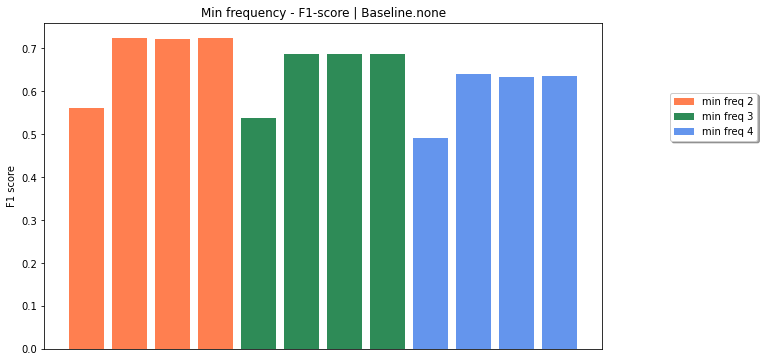

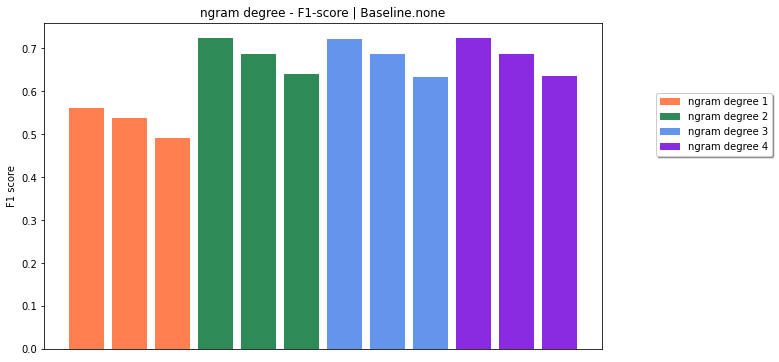

In [1456]:
plot_metrics(Baseline.none)

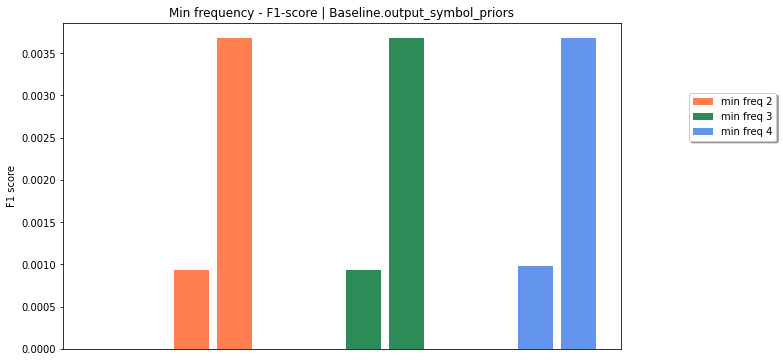

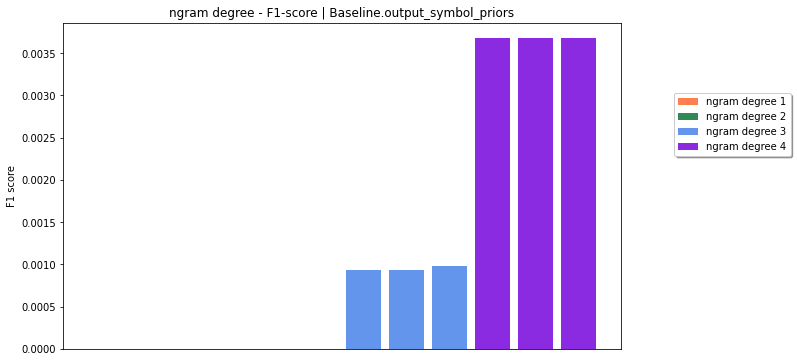

In [1457]:
plot_metrics(Baseline.output_symbol_priors)

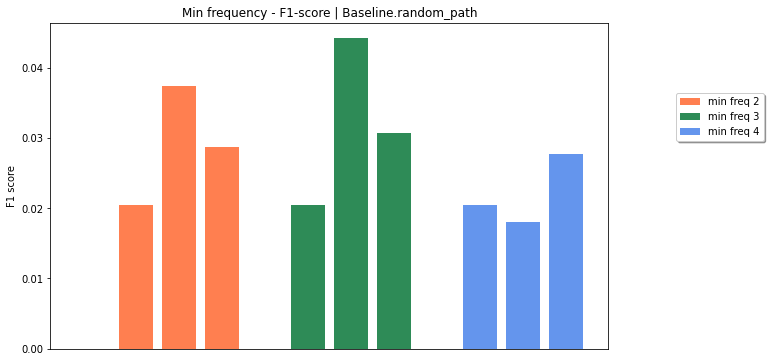

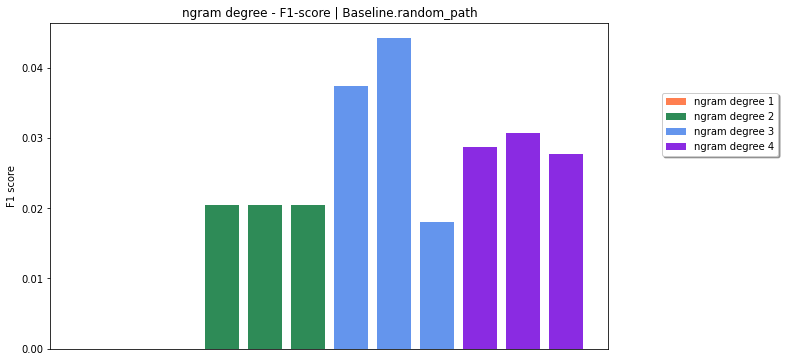

In [1458]:
plot_metrics(Baseline.random_path)

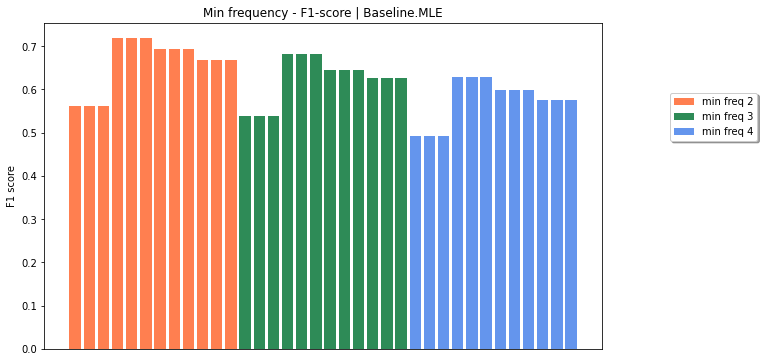

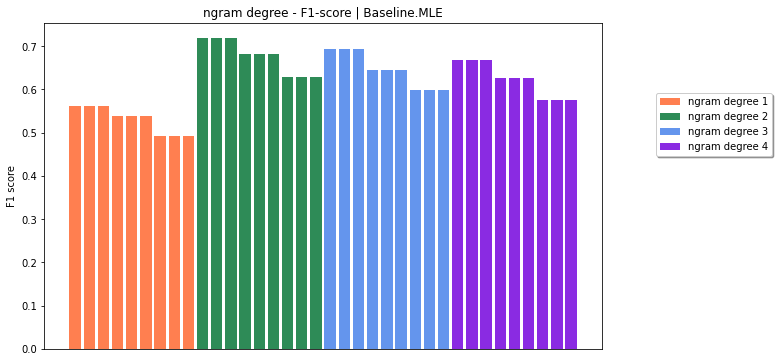

In [1459]:
plot_metrics(Baseline.MLE)

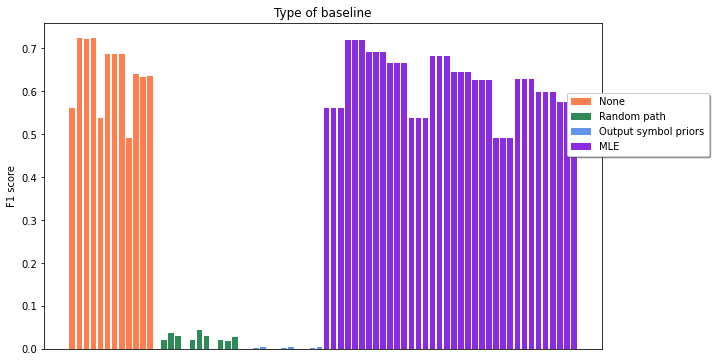

In [1462]:
degrees = [
    [ x['f1'] for x in list(filter(lambda i: str(i['baseline']) == str(Baseline.none), results)) ],
    [ x['f1'] for x in list(filter(lambda i: str(i['baseline']) == str(Baseline.random_path), results)) ],
    [ x['f1'] for x in list(filter(lambda i: str(i['baseline']) == str(Baseline.output_symbol_priors), results)) ],
    [ x['f1'] for x in list(filter(lambda i: str(i['baseline']) == str(Baseline.MLE), results)) ]
]

for v in range(1, len(degrees) + 1):
    plt.bar(range(start(degrees, v-1), start(degrees, v)), degrees[v-1], color=b_colors[v-1])

plt.title('Type of baseline')
plt.ylabel('F1 score')
plt.legend(labels=['None', 'Random path', 'Output symbol priors', 'MLE'], 
           loc='upper right', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)
plt.xticks([])
plt.show()

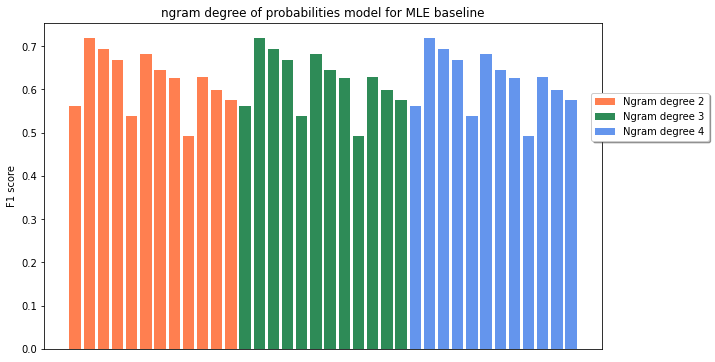

In [1461]:
dt = list(filter(lambda i: str(i['baseline']) == str(Baseline.MLE), results))

values = list(set([ i['prob_ngram_degree'] for i in dt ]))
    
degrees = [ [ x['f1'] for x in list(filter(lambda i: i['prob_ngram_degree'] == v, dt)) ]
                for v in values ]

for v in range(1, len(values) + 1):
    plt.bar(range(start(degrees, v-1), start(degrees, v)), degrees[v-1], color=b_colors[v-1])


plt.title('ngram degree of probabilities model for MLE baseline')
plt.ylabel('F1 score')
lbls = [ 'Ngram degree ' + str(v) for v in values ]
plt.legend(labels=lbls, loc='upper right', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)
plt.xticks([])
plt.show()

In [1463]:
best_SCLM = sorted(results, key=lambda x: x['f1'], reverse=True)[:10]

In [1464]:
ngram_methods = ['presmoothed', 'unsmoothed']
method_results = [] + best_SCLM

i = 0
for sclm in best_SCLM:
    print(i)
    i += 1
    for method in ngram_methods:
        method_results.append(compute_SCLM(min_freq=sclm['min_freq'], ngram_degree=sclm['ngram_degree'], baseline=sclm['baseline'], 
                         prob_ngram_degree=sclm['prob_ngram_degree'], ngram_method=method))

0
1
2
3
4
5
6
7
8
9


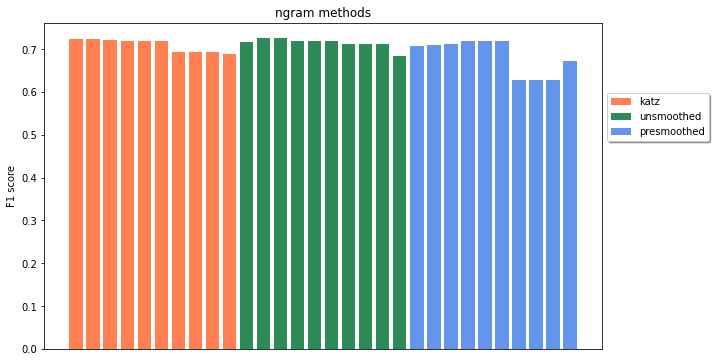

In [1497]:
values = list(set([ i['ngram_method'] for i in method_results ]))
    
degrees = [ [ x['f1'] for x in list(filter(lambda i: i['ngram_method'] == v, method_results)) ]
                for v in values ]

for v in range(1, len(values) + 1):
    plt.bar(range(start(degrees, v-1), start(degrees, v)), degrees[v-1], color=b_colors[v-1])


plt.title('ngram methods')
plt.ylabel('F1 score')
plt.legend(labels=values, loc='upper right', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)
plt.xticks([])
plt.show()

In [1491]:
best_SCLM_smoothed = sorted(best_SCLM, key=lambda x: x['f1'], reverse=True)[:10]

In [1644]:
norm_results = []
normalizations = [] + norm_rules

i = 0
for sclm in best_SCLM_smoothed:
    print(i)
    i+=1
    for norm in normalizations:
        print(norm)
        norm_results.append(compute_SCLM(min_freq=sclm['min_freq'], ngram_degree=sclm['ngram_degree'], 
                         baseline=sclm['baseline'], prob_ngram_degree=sclm['prob_ngram_degree'], 
                         ngram_method=sclm['ngram_method'], norm_rules=[norm]))

    norm_results.append(compute_SCLM(min_freq=sclm['min_freq'], ngram_degree=sclm['ngram_degree'], 
                         baseline=sclm['baseline'], prob_ngram_degree=sclm['prob_ngram_degree'], 
                         ngram_method=sclm['ngram_method'], norm_rules=normalizations))

0
PERSON
NORP
FAC
ORG
GPE
LOC
PRODUCT
EVENT
WORK_OF_ART
LAW
LANGUAGE
DATE
TIME
PERCENT
MONEY
QUANTITY
ORDINAL
CARDINAL
1
PERSON
NORP
FAC
ORG
GPE
LOC
PRODUCT
EVENT
WORK_OF_ART
LAW
LANGUAGE
DATE
TIME
PERCENT
MONEY
QUANTITY
ORDINAL
CARDINAL
2
PERSON
NORP
FAC
ORG
GPE
LOC
PRODUCT
EVENT
WORK_OF_ART
LAW
LANGUAGE
DATE
TIME
PERCENT
MONEY
QUANTITY
ORDINAL
CARDINAL
3
PERSON
NORP
FAC
ORG
GPE
LOC
PRODUCT
EVENT
WORK_OF_ART
LAW
LANGUAGE
DATE
TIME
PERCENT
MONEY
QUANTITY
ORDINAL
CARDINAL
4
PERSON
NORP
FAC
ORG
GPE
LOC
PRODUCT
EVENT
WORK_OF_ART
LAW
LANGUAGE
DATE
TIME
PERCENT
MONEY
QUANTITY
ORDINAL
CARDINAL
5
PERSON
NORP
FAC
ORG
GPE
LOC
PRODUCT
EVENT
WORK_OF_ART
LAW
LANGUAGE
DATE
TIME
PERCENT
MONEY
QUANTITY
ORDINAL
CARDINAL
6
PERSON
NORP
FAC
ORG
GPE
LOC
PRODUCT
EVENT
WORK_OF_ART
LAW
LANGUAGE
DATE
TIME
PERCENT
MONEY
QUANTITY
ORDINAL
CARDINAL
7
PERSON
NORP
FAC
ORG
GPE
LOC
PRODUCT
EVENT
WORK_OF_ART
LAW
LANGUAGE
DATE
TIME
PERCENT
MONEY
QUANTITY
ORDINAL
CARDINAL
8
PERSON
NORP
FAC
ORG
GPE
LOC
PRODUCT
EVENT
WORK

In [1645]:
def plot_norm(norm):
    values = list(set([ i['ngram_method'] for i in best_SCLM_smoothed ]))

    degrees = [ [ x['f1'] for x in list(filter(lambda i: i['ngram_method'] == v, best_SCLM_smoothed)) ]
                    for v in values ]

    for v in range(1, len(values) + 1):
        plt.bar(range(start(degrees, v-1), start(degrees, v)), degrees[v-1], color=b_colors[v-1])

    degrees = [ [ x['f1'] for x in list(filter(lambda i: i['ngram_method'] == v and norm == i['norm_rules']
                                               , norm_results)) ]
                    for v in values ]

    for v in range(1, len(values) + 1):
        plt.bar(range(start(degrees, v-1), start(degrees, v)), degrees[v-1], 
                color=b_colors[len(values) + v-1], alpha=0.7)


    plt.title('Comparison with normalization')
    plt.ylabel('F1 score')
    lbls = values + [ i + ' normalized by ' + ' '.join(norm) for i in values ]
    plt.legend(labels=lbls, loc='upper right', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)
    plt.xticks([])
    plt.show()

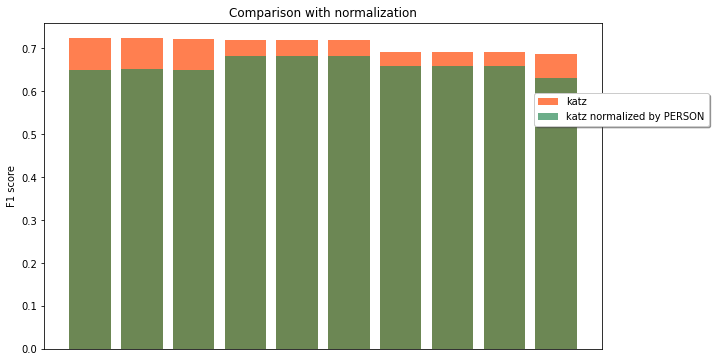

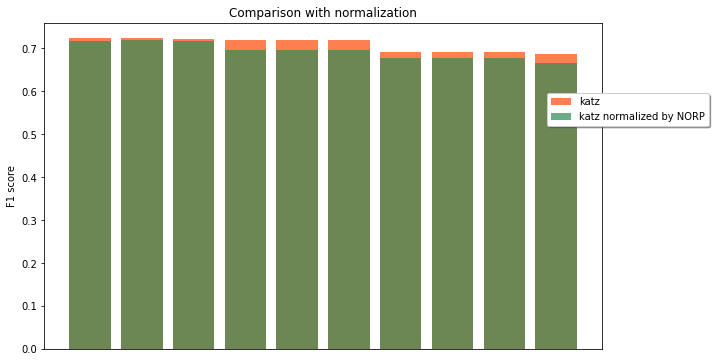

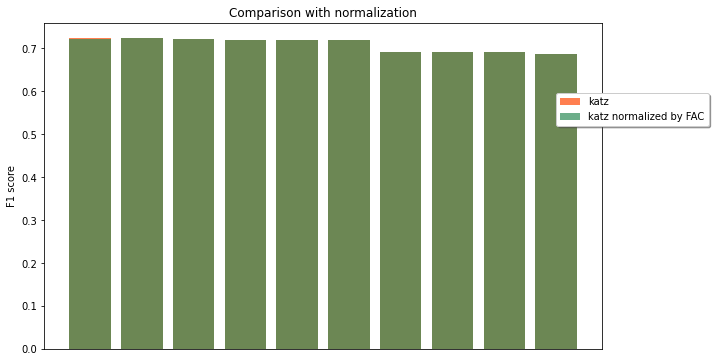

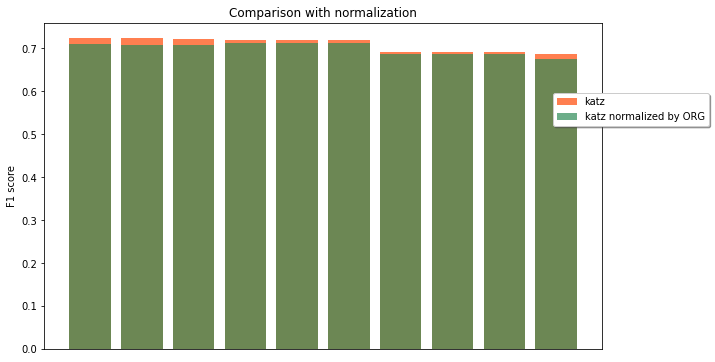

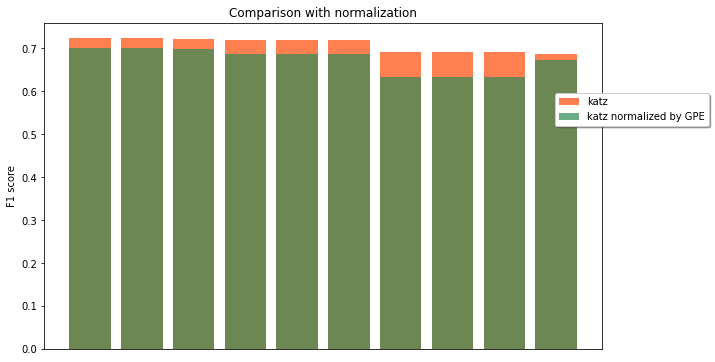

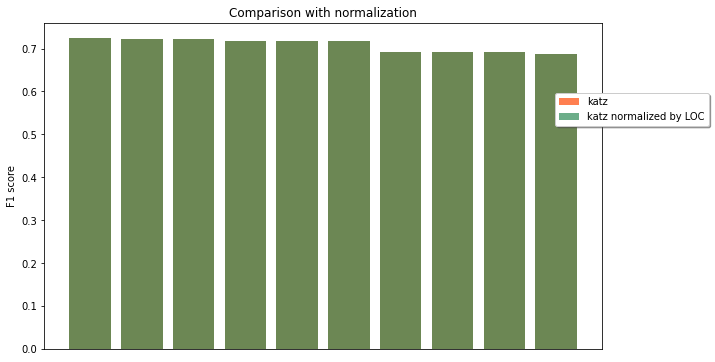

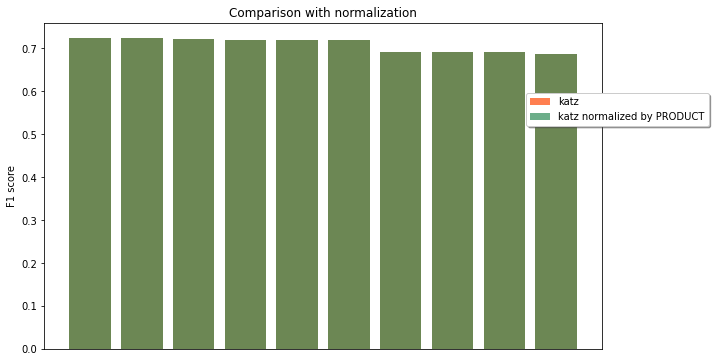

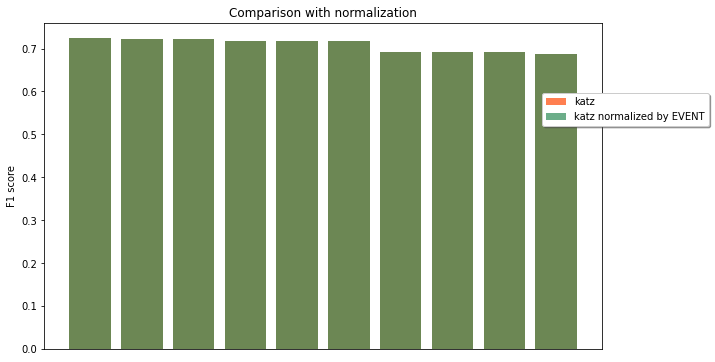

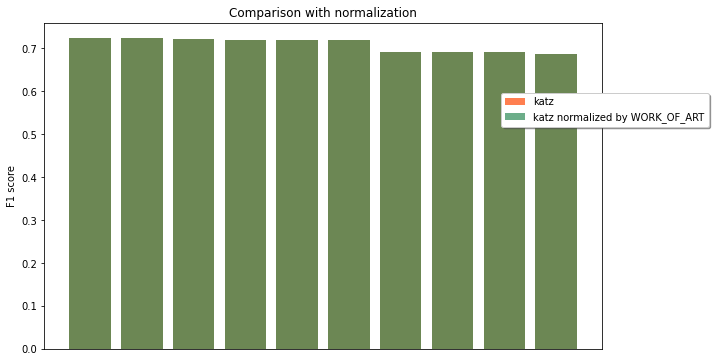

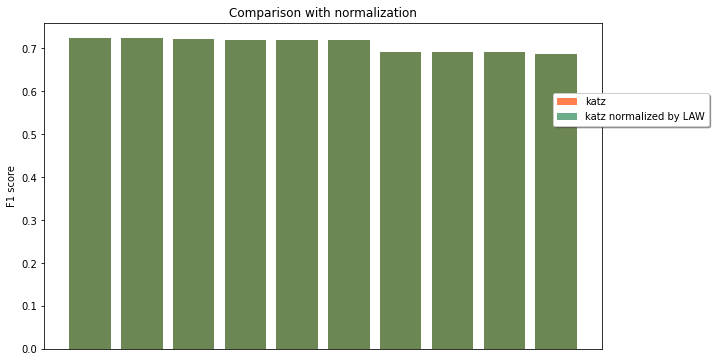

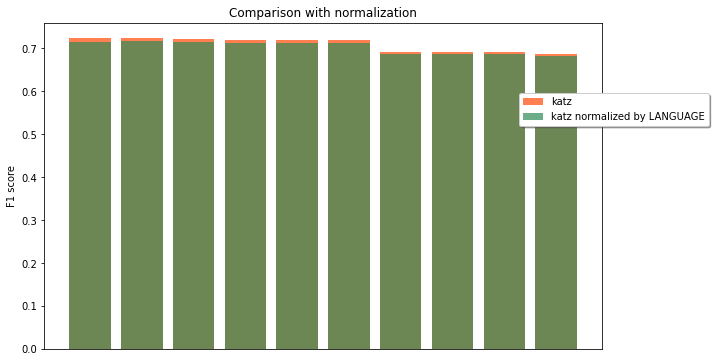

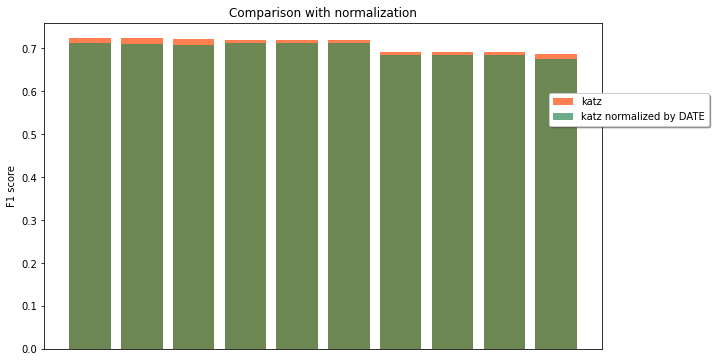

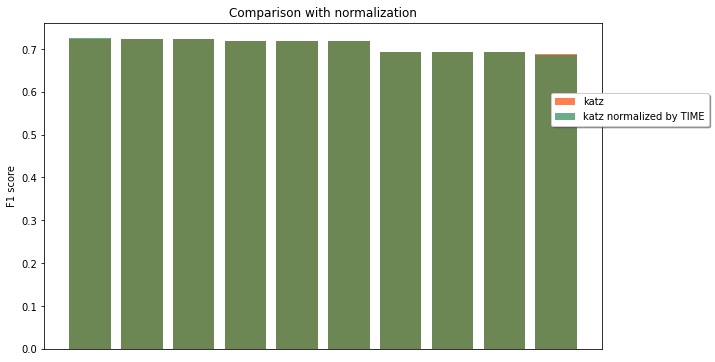

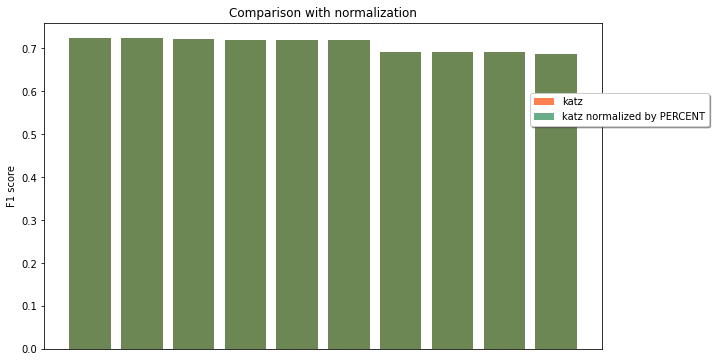

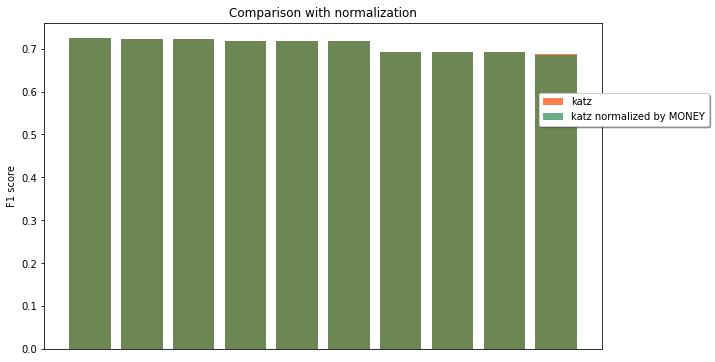

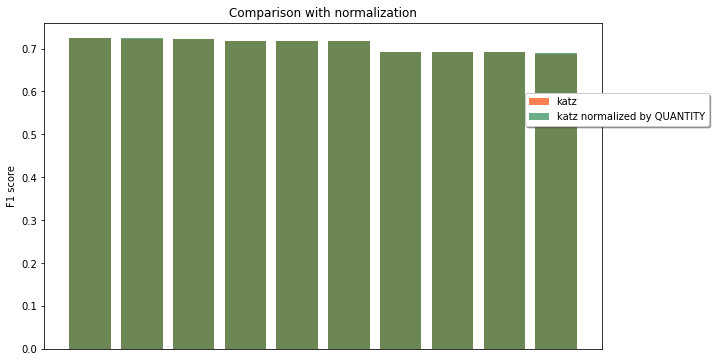

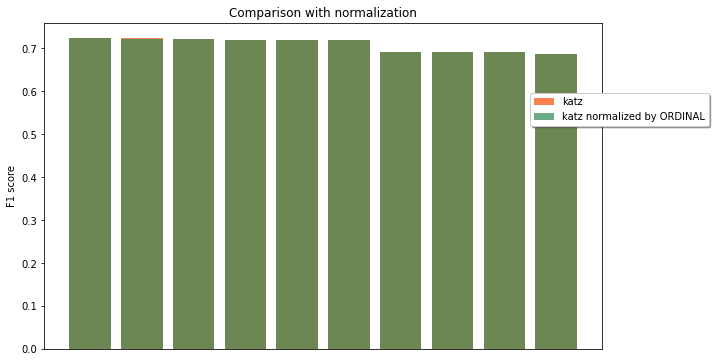

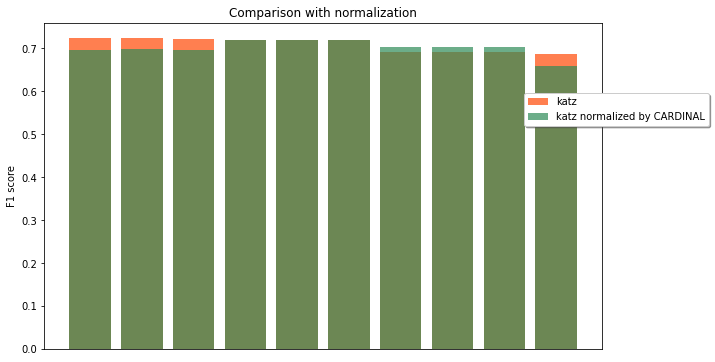

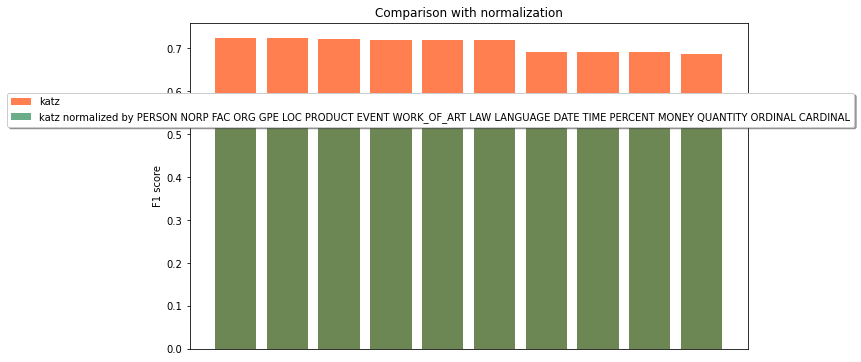

In [1646]:
for norm in normalizations:
    plot_norm([norm])
    
plot_norm(normalizations)